In [1]:
import math
import os
import keras as k
import numpy as np
import pandas as pd

/home/sai/code/personal/py-snippets/.env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = k.applications.VGG16(weights = 'imagenet',include_top=False)
x = model.get_layer('block5_conv3').output
x = k.layers.GlobalAveragePooling2D()(x)
x = k.layers.Dense(256, activation='relu')(x)
x = k.layers.Dropout(0.5)(x)
x = k.layers.Dense(1, activation='sigmoid')(x)
model_final = k.models.Model(inputs=model.input, outputs=x)

In [3]:
for layer in model.layers:
    layer.trainable = False

In [4]:
model_final.compile(optimizer = k.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True),
                    loss      = 'binary_crossentropy',
                    metrics   = ['accuracy'])

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
datagen = ImageDataGenerator( 
    featurewise_center            = True,
    rescale                       = 1.,
    rotation_range                = 10,
    width_shift_range             = .1,
    height_shift_range            = .1,
    shear_range                   = 0.2,
    zoom_range                    = 0.2,
    horizontal_flip               = False,
    vertical_flip                 = False,
    fill_mode                     = "reflect")

# normalization neccessary for correct image input to VGG16
datagen.mean=np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1,1,3)

# no data augmentation for validation and test set
validgen = ImageDataGenerator(rescale=1., featurewise_center=True)
validgen.mean=np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1,1,3)

In [7]:
img_width  = 512
img_height = 512

train_data_dir      = "data/train2"
validation_data_dir = "data/valid2"
test_data_dir       = "data/test2"

batch_size_train = 6
batch_size_val   = 6

train_gen = datagen.flow_from_directory(
        directory   = train_data_dir,
        target_size = (img_height, img_width),
        batch_size  = batch_size_train,
        class_mode  = "binary",
        shuffle     = True)

val_gen = validgen.flow_from_directory(
        directory   = validation_data_dir,
        target_size = (img_height, img_width),
        batch_size  = batch_size_val,
        class_mode  = "binary",
        shuffle     = False)

test_gen = validgen.flow_from_directory(
        directory   = test_data_dir,
        target_size = (img_height, img_width),
        batch_size  = batch_size_val,
        class_mode  = "binary",
        shuffle     = False)

train_samples      = len(train_gen.filenames)
validation_samples = len(val_gen.filenames)
test_samples       = len(test_gen.filenames)

Found 1312 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 788 images belonging to 2 classes.


In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=1e-4,
                           mode='min'),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4,
                               mode='min'),
             ModelCheckpoint(monitor='val_loss',
                             filepath='data/weights/best_weights_m2.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')]

In [9]:
model_final.fit_generator(generator        = train_gen,
                          epochs           = 50, 
                          steps_per_epoch  = math.ceil(train_samples / batch_size_train), 
                          validation_data  = val_gen, 
                          validation_steps = math.ceil(validation_samples / batch_size_val), 
                          verbose          = 2,
                          callbacks        = callbacks,
                          class_weight     = {0: 96/1312, 1: 1216/1312})

Epoch 1/50
 - 128s - loss: 0.1089 - acc: 0.5213 - val_loss: 0.7338 - val_acc: 0.5782
Epoch 2/50
 - 122s - loss: 0.0937 - acc: 0.6016 - val_loss: 0.7032 - val_acc: 0.6164
Epoch 3/50
 - 126s - loss: 0.0856 - acc: 0.6629 - val_loss: 0.6562 - val_acc: 0.6336
Epoch 4/50
 - 126s - loss: 0.0823 - acc: 0.6823 - val_loss: 0.6230 - val_acc: 0.6584
Epoch 5/50
 - 133s - loss: 0.0759 - acc: 0.7097 - val_loss: 0.6054 - val_acc: 0.6775
Epoch 6/50
 - 134s - loss: 0.0759 - acc: 0.7203 - val_loss: 0.5812 - val_acc: 0.7004
Epoch 7/50
 - 126s - loss: 0.0717 - acc: 0.7409 - val_loss: 0.5775 - val_acc: 0.6908
Epoch 8/50
 - 126s - loss: 0.0746 - acc: 0.7306 - val_loss: 0.5673 - val_acc: 0.7004
Epoch 9/50
 - 133s - loss: 0.0703 - acc: 0.7466 - val_loss: 0.5040 - val_acc: 0.7481
Epoch 10/50
 - 126s - loss: 0.0708 - acc: 0.7492 - val_loss: 0.6011 - val_acc: 0.6698
Epoch 11/50
 - 126s - loss: 0.0657 - acc: 0.7382 - val_loss: 0.4884 - val_acc: 0.7481
Epoch 12/50
 - 127s - loss: 0.0673 - acc: 0.7439 - val_loss: 0.

In [10]:
model_final.load_weights('data/weights/best_weights_m2.hdf5')

In [11]:
for layer in model_final.layers:
    layer.trainable = True

In [12]:
model_final.compile(optimizer = k.optimizers.SGD(lr=0.000001, momentum=0.9, nesterov=True),
                    loss      = 'binary_crossentropy',
                    metrics   = ['accuracy'])

In [13]:
model_final.fit_generator(generator        = train_gen,
                          epochs           = 50, 
                          steps_per_epoch  = math.ceil(train_samples / batch_size_train), 
                          validation_data  = val_gen, 
                          validation_steps = math.ceil(validation_samples / batch_size_val), 
                          verbose          = 2,
                          callbacks        = callbacks,
                          class_weight     = {0: 96/1312, 1: 1216/1312})

Epoch 1/50
 - 286s - loss: 0.0663 - acc: 0.7774 - val_loss: 0.4993 - val_acc: 0.7424
Epoch 2/50
 - 274s - loss: 0.0648 - acc: 0.7865 - val_loss: 0.5000 - val_acc: 0.7424
Epoch 3/50
 - 273s - loss: 0.0651 - acc: 0.7645 - val_loss: 0.4992 - val_acc: 0.7443
Epoch 4/50
 - 275s - loss: 0.0658 - acc: 0.7694 - val_loss: 0.5008 - val_acc: 0.7424
Epoch 5/50
 - 279s - loss: 0.0665 - acc: 0.7797 - val_loss: 0.5075 - val_acc: 0.7385

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 6/50
 - 276s - loss: 0.0679 - acc: 0.7534 - val_loss: 0.5076 - val_acc: 0.7385
Epoch 00006: early stopping


In [14]:
model_final.load_weights('data/weights/best_weights_m2.hdf5')

In [29]:
test_gen = validgen.flow_from_directory(
        directory   = test_data_dir,
        target_size = (img_height, img_width),
        batch_size  = 6,
        class_mode  = "binary",
        shuffle     = False)
test_samples = len(test_gen.filenames)
preds = model_final.predict_generator(test_gen, math.ceil(test_samples / 6))

Found 788 images belonging to 2 classes.


In [30]:
preds = [x[0] for x in preds]

In [31]:
from sklearn.metrics import roc_auc_score

In [32]:
roc_auc_score(test_gen.classes, preds)

0.7883325460557393

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_gen.classes, preds)

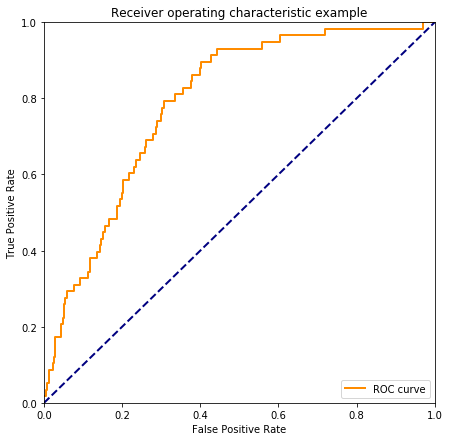

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [50]:
pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

,fpr,thresholds,tpr
0,0.000000,0.971229,0.017241
1,0.004110,0.917573,0.017241
2,0.004110,0.915734,0.034483
3,0.006849,0.911139,0.034483
4,0.006849,0.892974,0.051724
5,0.013699,0.853440,0.051724
6,0.013699,0.842849,0.086207
7,0.023288,0.826775,0.086207
8,0.023288,0.817994,0.103448
9,0.026027,0.814507,0.103448


In [51]:
metrics = pd.DataFrame({'pred': preds,
              'filename': test_gen.filenames,
              'class': test_gen.classes})\
    .assign(predicted_class = lambda x: (x.pred > 0.368988).astype('int64'))

In [52]:
metrics.head(2)

,class,filename,pred,predicted_class
0,0,no/0_z3_fb_x1_y1.jpg,0.718023,1
1,0,no/0_z3_fb_x1_y2.jpg,0.410323,1


In [54]:
metrics.groupby(['class', 'predicted_class'])['filename'].count()

class  predicted_class
0      0                  438
       1                  292
1      0                    7
       1                   51
Name: filename, dtype: int64

In [57]:
metrics.groupby(['class', 'predicted_class']).tail(1)

,class,filename,pred,predicted_class
728,0,no/9_z3_fl_x2_y1.jpg,0.181463,0
729,0,no/9_z3_fr_x2_y2.jpg,0.707381,1
786,1,yes/96_z3_fb_x2_y1.jpg,0.813814,1
787,1,yes/98_z3_fb_x1_y1.jpg,0.223920,0


In [61]:
metrics[(metrics['class'] == 0) & (metrics.predicted_class == 1)].sample(10)

,class,filename,pred,predicted_class
281,0,no/155_z3_fr_x2_y1.jpg,0.426802,1
481,0,no/46_z3_ff_x2_y2.jpg,0.408961,1
305,0,no/159_z3_fr_x1_y1.jpg,0.788937,1
274,0,no/154_z3_ff_x2_y2.jpg,0.404522,1
309,0,no/15_z3_fr_x2_y1.jpg,0.463953,1
575,0,no/66_z3_fb_x2_y2.jpg,0.397490,1
527,0,no/57_z3_fl_x2_y1.jpg,0.721310,1
549,0,no/61_z3_ff_x2_y2.jpg,0.583770,1
202,0,no/142_z3_fb_x1_y2.jpg,0.842724,1
225,0,no/147_z3_fb_x2_y2.jpg,0.635008,1
